# IMPORT LIBRARY AND DATA

In [1]:
import numpy as np
import numba as nb
import math
import matplotlib.pyplot as plt
import pandas as pd
import time
from numba import njit, prange
from os import listdir
from os.path import isfile, join

%matplotlib inline
plt.style.use(['science','ieee'])

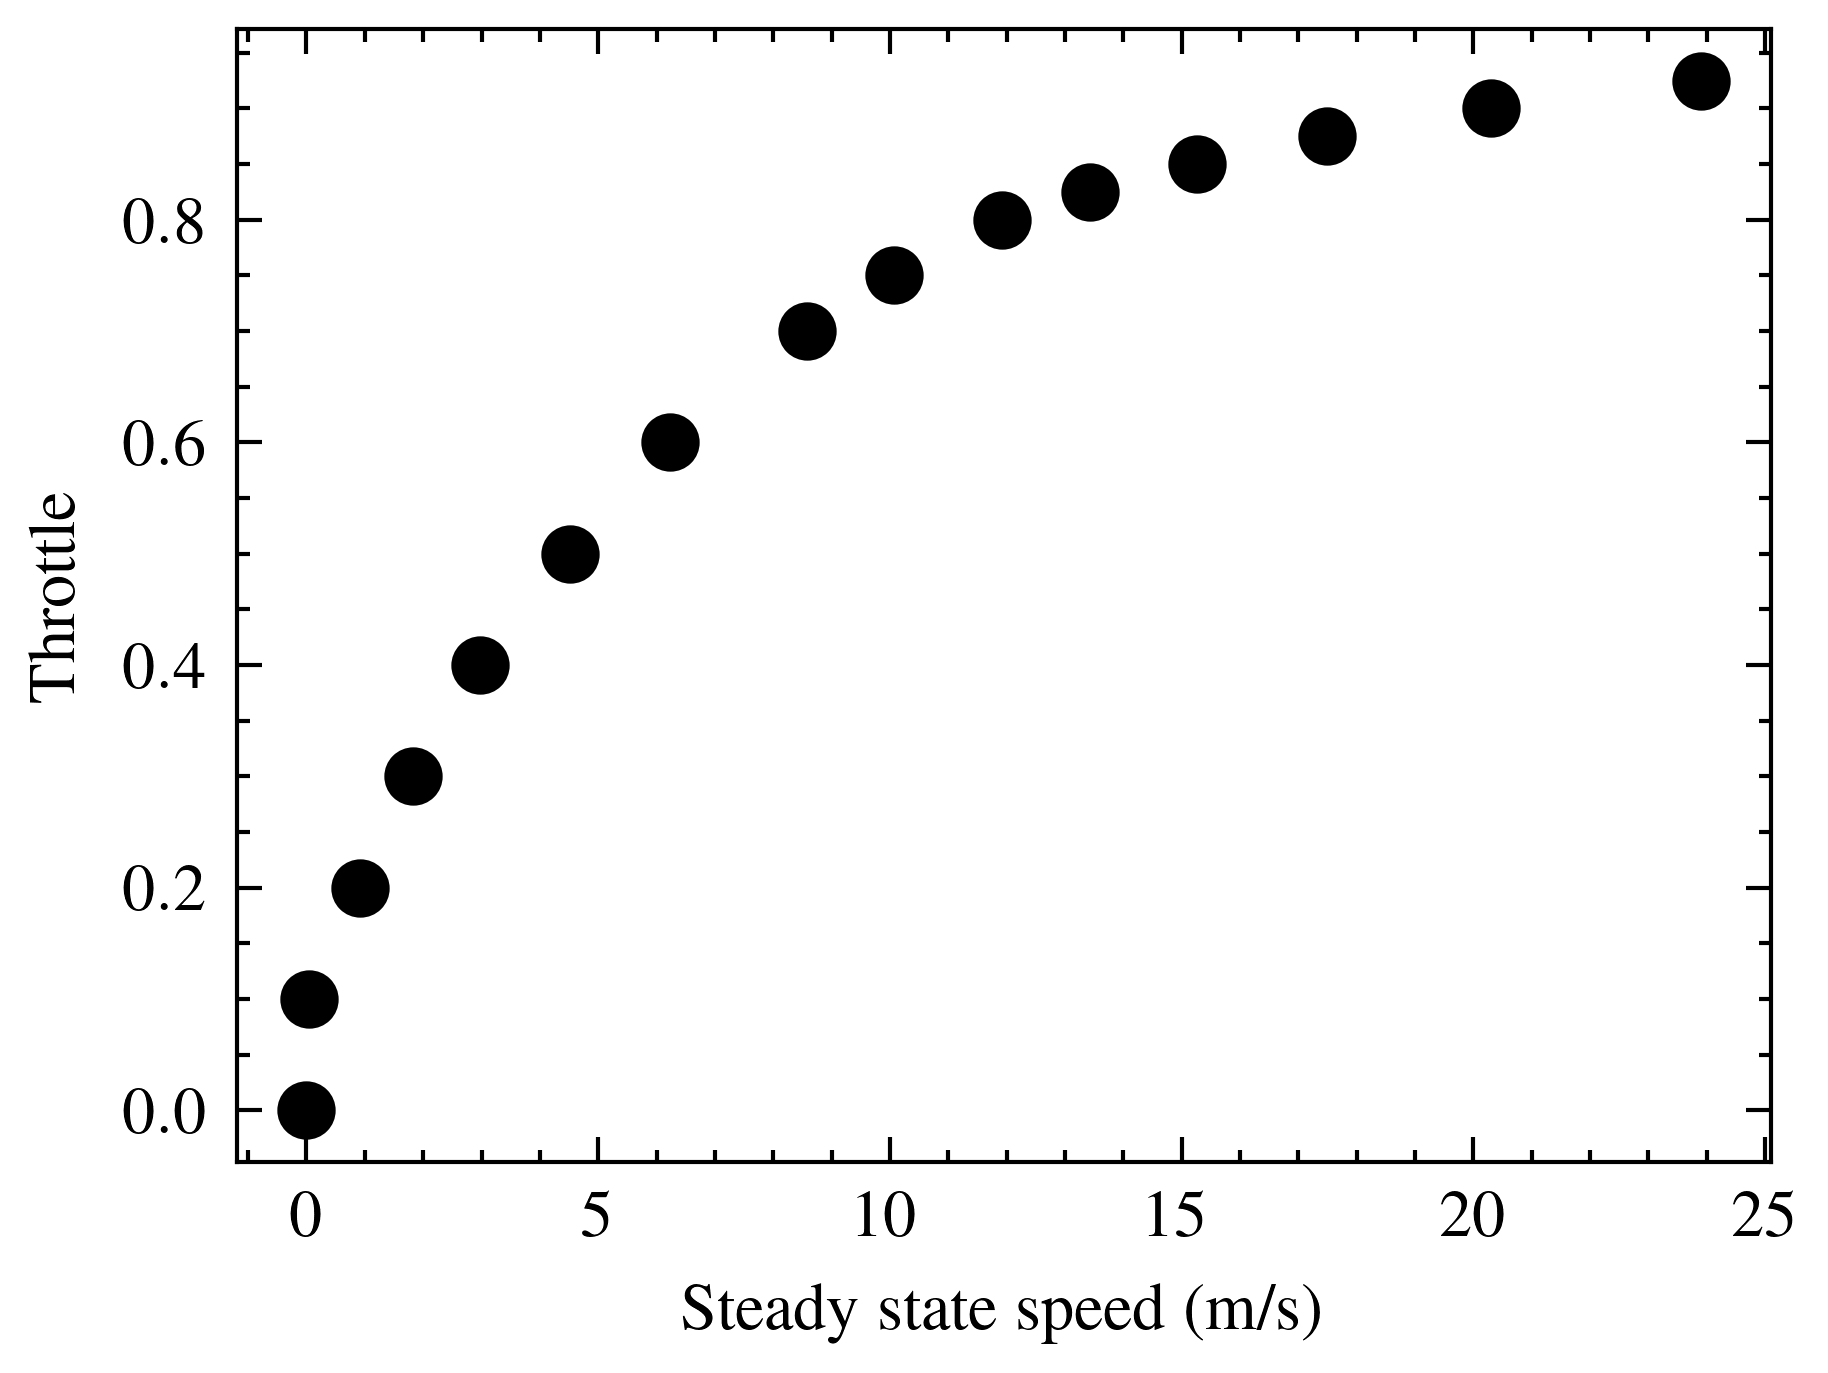

In [2]:
df = pd.read_csv('../steady_state_response.csv')
v = np.array(df.ssv)
u = np.array(df.u)


plt.figure()
plt.scatter(v, u)
plt.xlabel('Steady state speed (m/s)')
plt.ylabel('Throttle')
plt.show()

# MAKE FUNCTION

## Generate population

In [3]:
def generate_population(num, dim, rng):
    """
    Generate population:
        Input:
            num: number of population (integer)
            dim: number of parameters (integer)
            rng: range number used in initialization (list or numpy array)
        Output:
            pop: initial position of the population (numpy array)
    """
    pop = np.zeros((num,dim))
    for i in range(dim):
        lim = rng[i]
        pop[:, i] = np.random.uniform(lim[0], lim[1], size=num)
    return pop

## Constraint

In [4]:
@njit
def admissible(param):
    b1, b2, b3 = param
    if b1 < 0. or b2 > 0. or b3 < 0.:
        return False
    else:
        return True
_ = admissible(np.random.randn(3))

## Forward propagation

In [5]:
@njit
def forward_propagation(u, param):
    b1, b2, b3 = param
    
    out = b1 * (1 - np.exp(b2*(u))) + b3
    out = np.fmax(out, 0.)
    
    # When the vehicle is not moving
    out[u <= 1e-2] = 0.
    
    return out

_ = forward_propagation(np.array([0.0, 0.1]), np.ones(3)*0.5)

## Cost and metric

In [6]:
@njit
def cost(u, v, param):
    error = v - forward_propagation(u, param)
    cost = np.mean(error**2)
    return cost
_ = cost(v, u, np.ones(3)*0.5)

In [7]:
@njit
def calculate_total_cost(param):    
    if admissible(param):
        loss = cost(v, u, param)
    else:
        loss = np.Inf
    return loss
_ = calculate_total_cost(np.ones(3)*0.5)

In [8]:
@njit(parallel=True)
def population_cost(population):
    length = population.shape[0]
    losses = np.zeros(length)
    for ii in prange(length):
        losses[ii] = calculate_total_cost(population[ii])
    return losses
_ = population_cost(np.random.randn(2,3))

## Optimization Algorithm

In [9]:
@njit
def pso(population, pop_velocity, global_, global_loss, best_pos_local,
        best_local_loss, w_max, w_min, c1, c2, iteration, max_iter):
    num = population.shape[0]
    dim = population.shape[1]
    
    # Initial conditions
    ppos_vector = np.copy(population)
    pvel_vector = np.copy(pop_velocity)
    gbest_pos = np.copy(global_)
    gfit_value = global_loss + 0.0 # to avoid shallow copy
    pbest_pos = np.copy(best_pos_local)
    pfit_value = np.copy(best_local_loss)

    # Additional variables for catching the next global best
    next_gbest_pos = np.copy(gbest_pos)
    next_gfit_value = gfit_value + 0.0 # to avoid shallow copy
    
    # Calculate w based on w_max, w_min, current number of iteration,
    # and the maximum iteration
    w = w_max - (w_max - w_min) * iteration / max_iter
    
    for i in range(num):        
        # Get random numbers for r1 and r2
        r1 = np.random.uniform(0., 1.)
        r2 = np.random.uniform(0., 1.)
        
        # Update the velocity and position vector
        d1 = pbest_pos[i] - ppos_vector[i]
        d2 = gbest_pos - ppos_vector[i]
        pvel_vector[i] = w*pvel_vector[i] + c1*r1*d1+ c2*r2*d2
        ppos_vector[i] = pvel_vector[i] + ppos_vector[i]
        
        # Calculate the cost function or fit value
        cost_func = calculate_total_cost(ppos_vector[i])
        
        # Update the next local best for i-th particle if applicable
        if(pfit_value[i] > cost_func):
            pfit_value[i] = cost_func + 0.0 # to avoid shallow copy
            pbest_pos[i] = np.copy(ppos_vector[i])
                
        # Update the next global best if applicable
        if(next_gfit_value > cost_func):
            next_gfit_value = cost_func  + 0.0 # to avoid shallow copy
            next_gbest_pos = np.copy(ppos_vector[i])
        
    return ppos_vector, pvel_vector, pbest_pos, pfit_value, next_gbest_pos, next_gfit_value

xx1 = np.ones((2, 3))*1.0
xx2 = np.ones(2)
xx3 = np.ones(3)*0.5
_ = pso(xx1, xx1, xx3, 100.0, xx1*0.5, xx2, 0.9, 0.4, 0.7, 0.8, 0, 20)    

# SIMULATION

In [10]:
num = 25
n_sim = 50
n_itr = 5000

r_b1 = [0.,  2.]
r_b2 = [0., -2.]
r_b3 = [0.,  2.]

rng = [r_b1, r_b2, r_b3]
dim = len(rng)

w_max = 0.9
w_min = 0.4
c1 = 0.7
c2 = 0.8

param_history = np.zeros((n_sim, dim))
loss_history = np.ones(n_sim)*np.Inf

the_best_param_history = np.zeros((n_itr, dim))
the_best_loss_history = np.zeros(n_itr)

for j in range(n_sim):
    population = generate_population(num, dim, rng)
    rng_vel = [[-max([abs(rng[i][0]), abs(rng[i][1])]), max([abs(rng[i][0]), abs(rng[i][1])])] for i in range(len(rng))]
    pop_velocity = generate_population(num, dim, rng_vel)
    global_ = None
    global_loss_ = np.Inf
    local_best_pos = np.copy(population)
    
    loss_population = population_cost(population)
    loss_population[np.isnan(loss_population)] = np.Inf
    min_idx = np.argmin(loss_population)
    min_loss = loss_population[min_idx]
    if global_loss_ > min_loss:
        global_loss_ = min_loss
        global_ = np.copy(population[min_idx, :])
        
    global_history = np.empty((n_itr, dim))
    global_history[0] = global_
    global_loss_history = np.empty(n_itr)
    global_loss_history[0] = global_loss_
    for i in range(1, n_itr):
        # Particle Swarm Optimization
        population, pop_velocity, local_best_pos, loss_population, global_, global_loss_ = pso(
            population, pop_velocity, global_, global_loss_, local_best_pos, loss_population,
            w_max, w_min, c1, c2, i, n_itr
        )
        
        global_history[i] = global_
        global_loss_history[i] = global_loss_
    
    if np.min(loss_history) > global_loss_history[-1]:
        the_best_loss_history = np.copy(global_loss_history)
        the_best_param_history = np.copy(global_history)
        
    param_history[j] = np.copy(global_history[-1])
    loss_history[j] = np.copy(global_loss_history[-1])
    
    print('simulation: {} || global loss: {:.10f} || the best loss: {:.10f}'.format(j, global_loss_history[-1], the_best_loss_history[-1]))

simulation: 0 || global loss: 0.0000117460 || the best loss: 0.0000117460
simulation: 1 || global loss: 0.0000117460 || the best loss: 0.0000117460
simulation: 2 || global loss: 0.0000117460 || the best loss: 0.0000117460
simulation: 3 || global loss: 0.0000117460 || the best loss: 0.0000117460
simulation: 4 || global loss: 0.0000117460 || the best loss: 0.0000117460
simulation: 5 || global loss: 0.0000117460 || the best loss: 0.0000117460
simulation: 6 || global loss: 0.0000117460 || the best loss: 0.0000117460
simulation: 7 || global loss: 0.0000117460 || the best loss: 0.0000117460
simulation: 8 || global loss: 0.0000117460 || the best loss: 0.0000117460
simulation: 9 || global loss: 0.0000117460 || the best loss: 0.0000117460
simulation: 10 || global loss: 0.0000117460 || the best loss: 0.0000117460
simulation: 11 || global loss: 0.0000117460 || the best loss: 0.0000117460
simulation: 12 || global loss: 0.0000117460 || the best loss: 0.0000117460
simulation: 13 || global loss: 0.00

In [11]:
# Save the simulation
np.save('result/param_history.npy', param_history)
np.save('result/loss_history.npy', loss_history)
np.save('result/the_best_loss_history.npy', the_best_loss_history)
np.save('result/the_best_param_history.npy', the_best_param_history)

f = open("result/sim.cfg", "w+")
f.writelines('num: {} # The number of flowers\n'.format(num))
f.writelines('n_sim: {} # The number of simulation loop\n'.format(n_sim))
f.writelines('n_itr: {} # The number of iteration for each simulation\n'.format(n_itr))
f.writelines('\n# The boundary of the initialization value\n')
f.writelines('r_b1: {}\n'.format(r_b1))
f.writelines('r_b2: {}\n'.format(r_b2))
f.writelines('r_b3: {}\n'.format(r_b3))
f.writelines('\n# The PSO hyperparameters\n')
f.writelines('w_max: {}\n'.format(w_max))
f.writelines('w_min: {}\n'.format(w_min))
f.writelines('c1: {}\n'.format(c1))
f.writelines('c2: {}\n'.format(c2))
f.writelines('max_iter: {}\n'.format(n_itr))
f.close()

# RESULT

In [12]:
# Load the model
the_best_param_history = np.load('result/the_best_param_history.npy')
the_best_loss_history = np.load('result/the_best_loss_history.npy')

In [13]:
print('Minimum Cost: {}'.format(the_best_loss_history[-1]))
print('Parameters:')
print(the_best_param_history[-1])

Minimum Cost: 1.1745972296653385e-05
Parameters:
[ 0.85009553 -0.14497243  0.09623465]


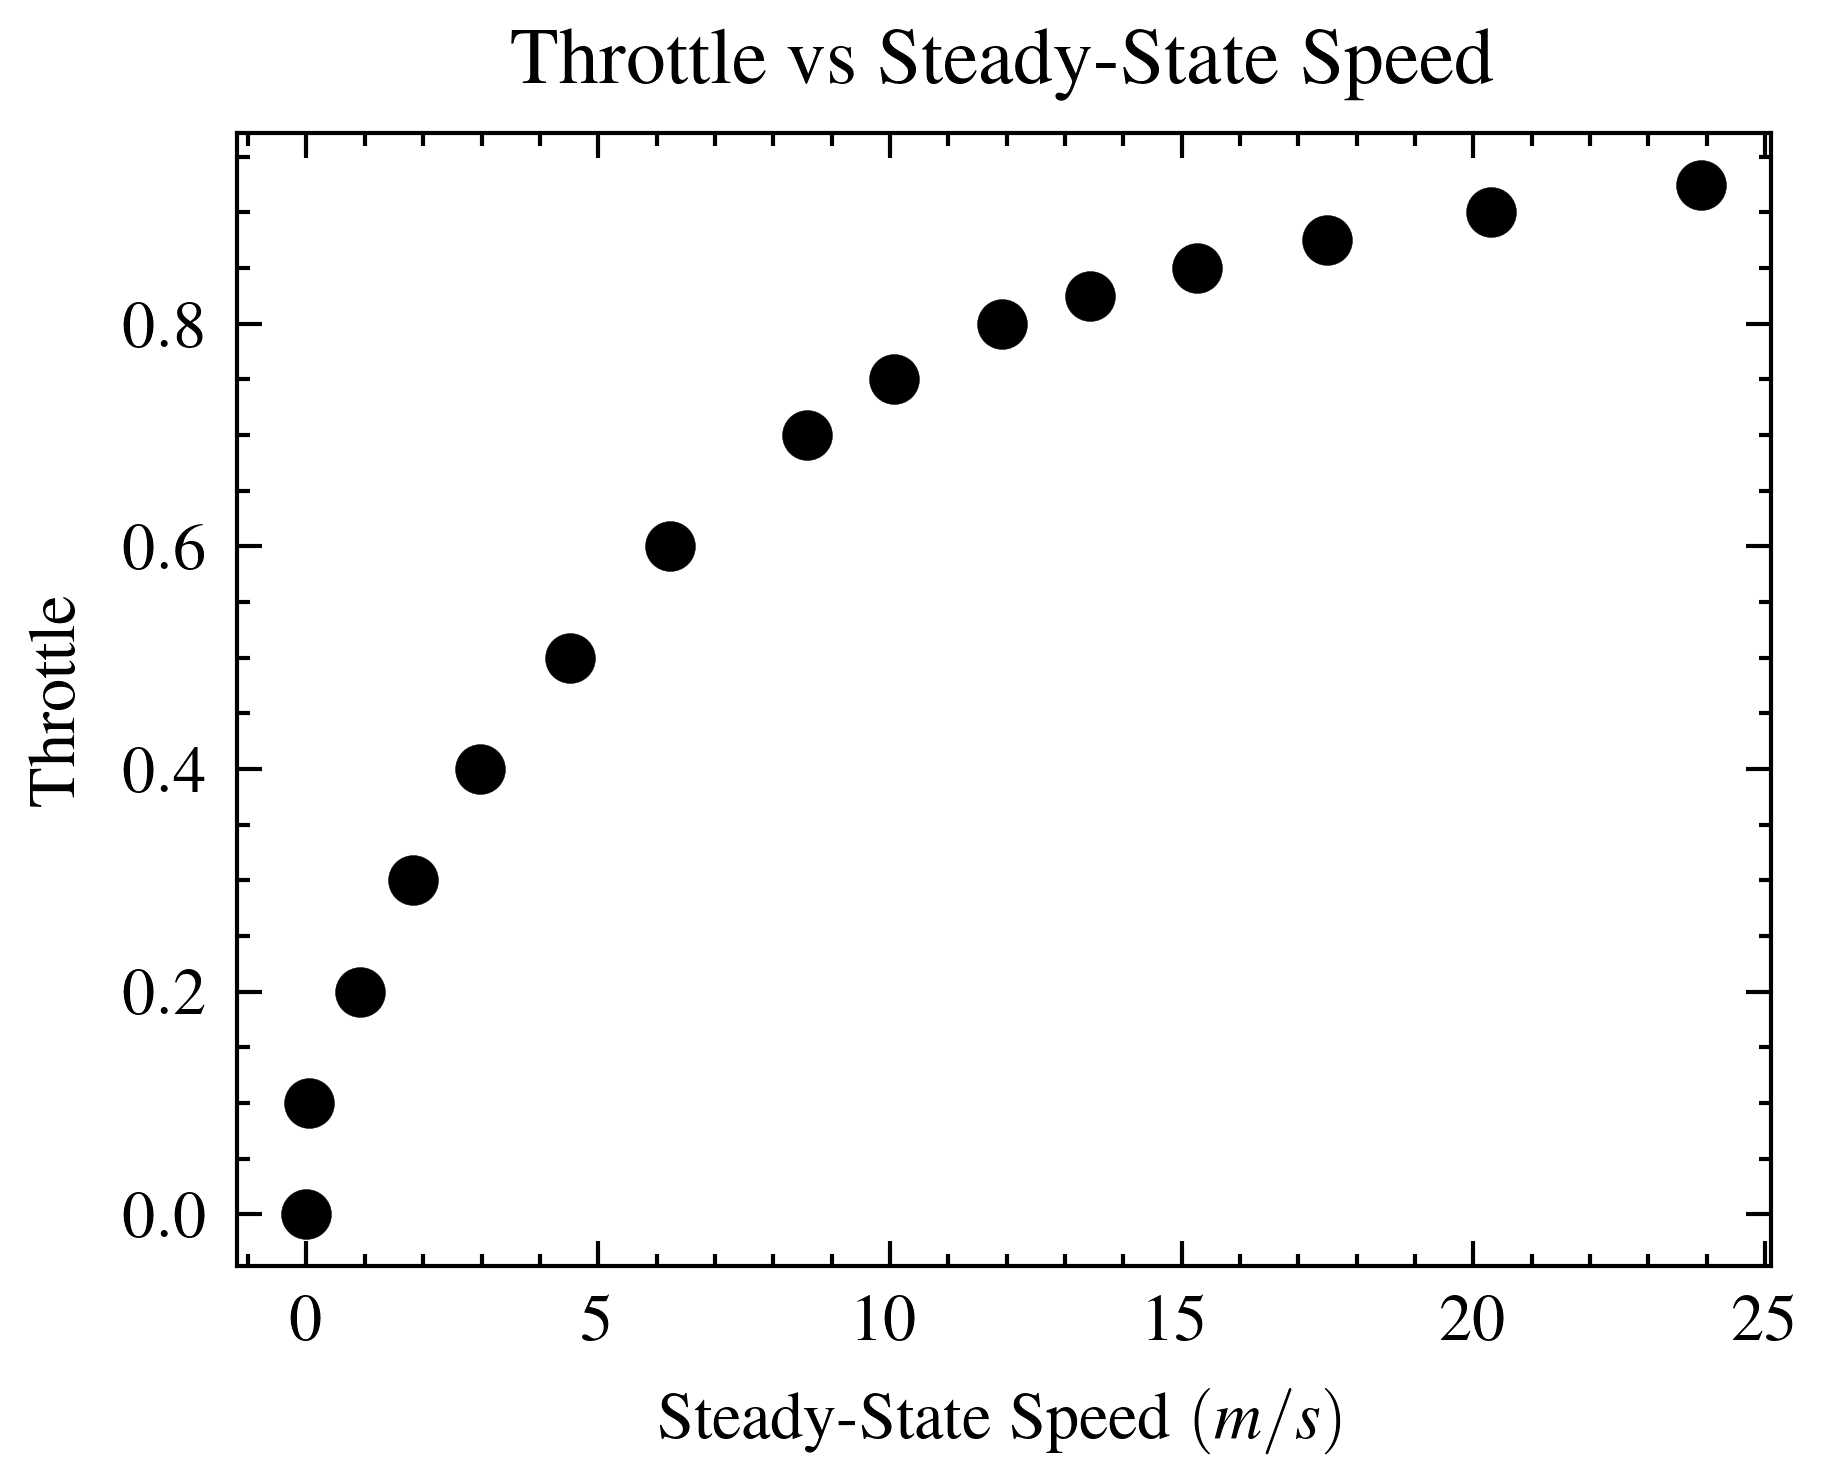

In [14]:
plt.scatter(v, u, linewidth=0.05)
plt.xlabel(r'Steady-State Speed $(m/s)$')
plt.ylabel('Throttle')
plt.title('Throttle vs Steady-State Speed')
plt.savefig('img/throttle_vs_speed', dpi=600, transparent=True, bbox_inches='tight',)
plt.show()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


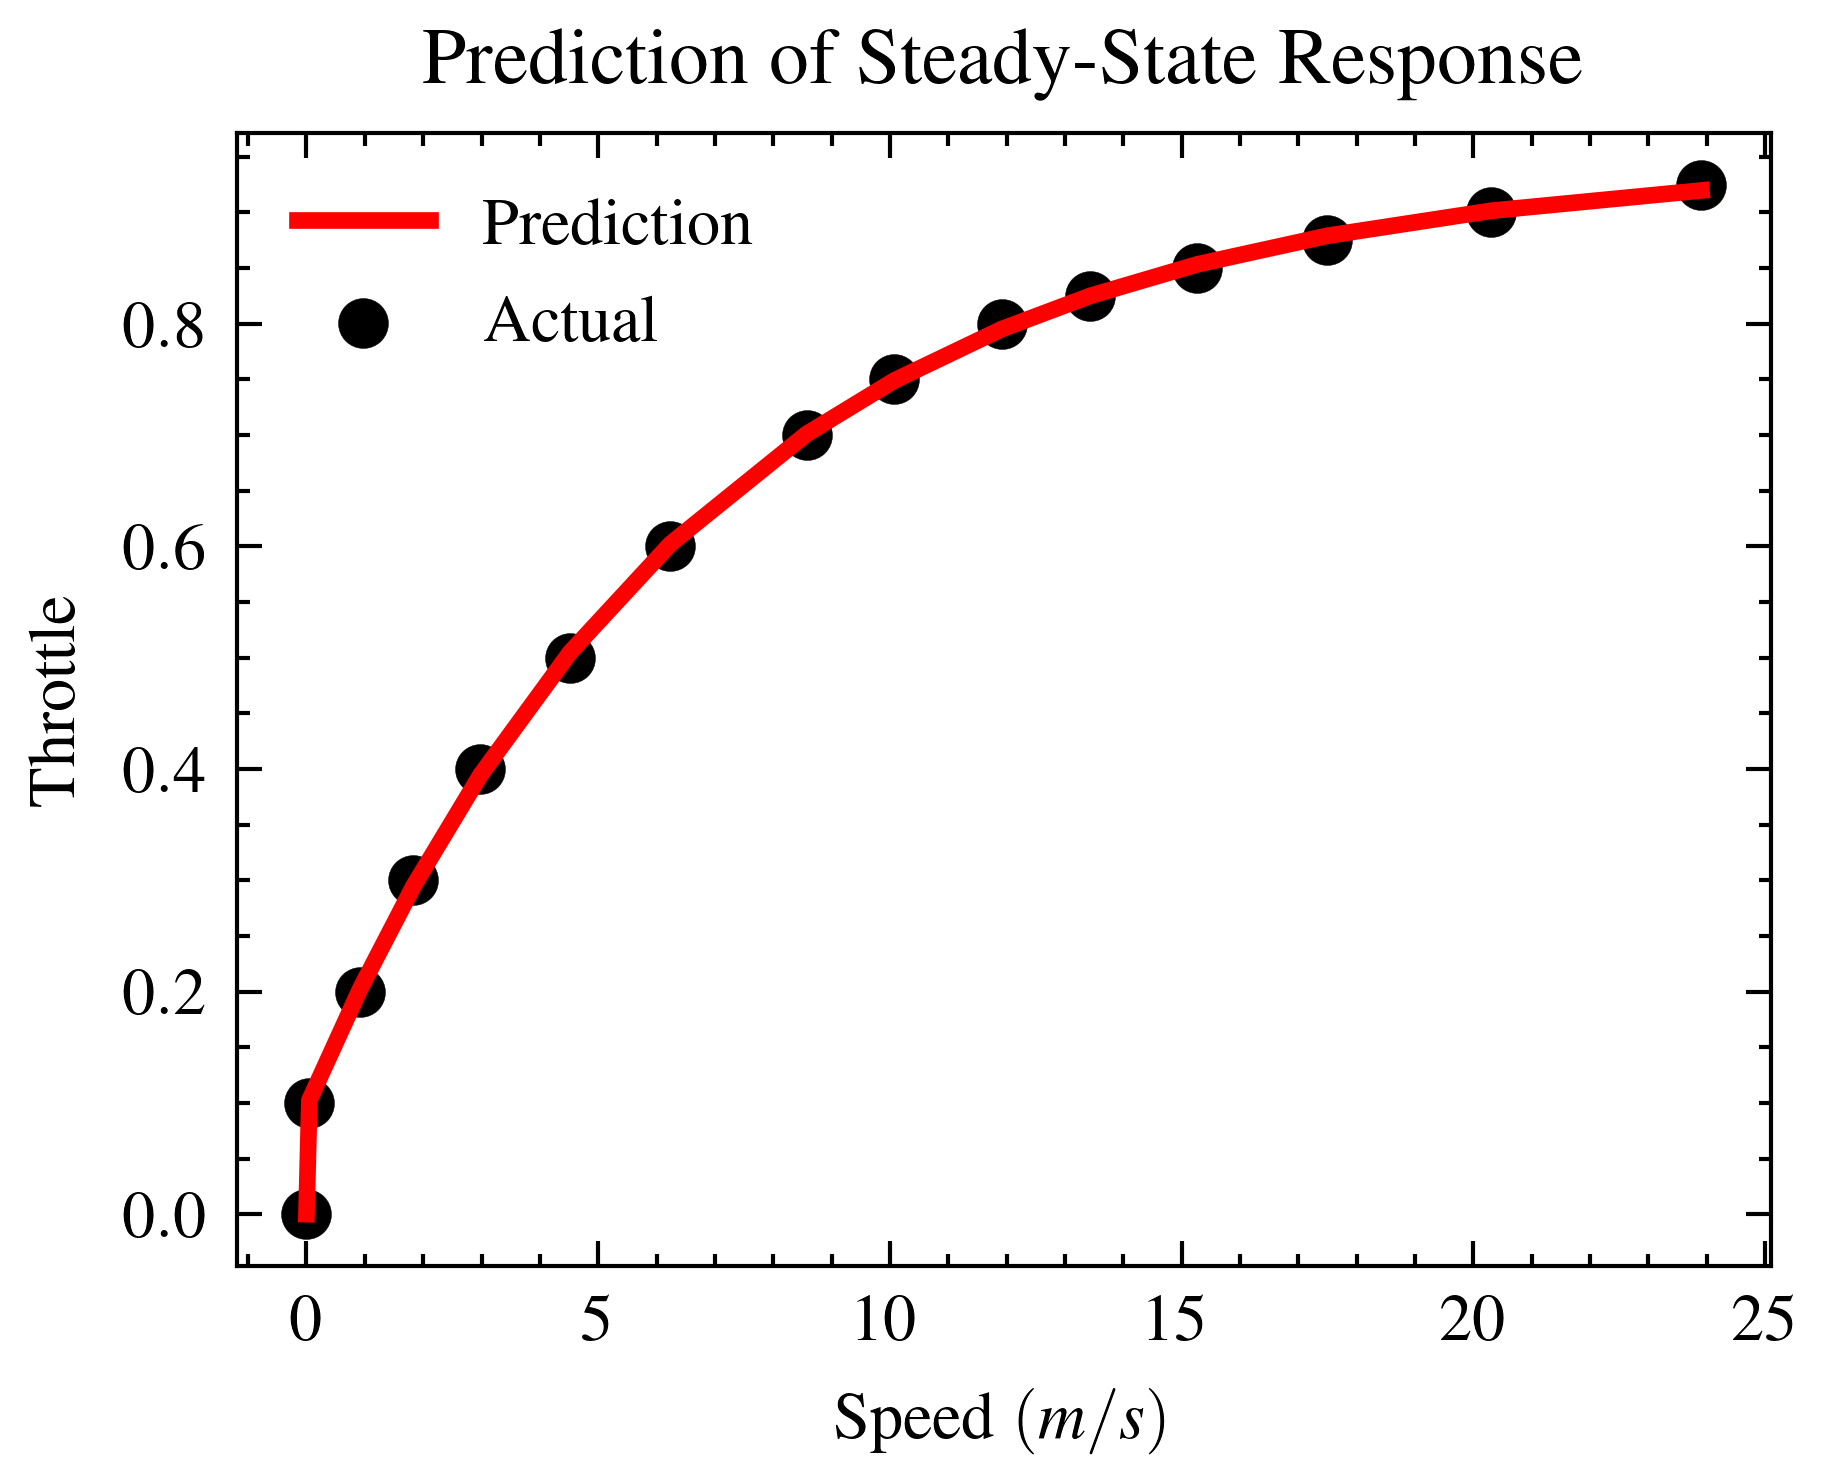

In [15]:
plt.scatter(v, u, label='Actual', linewidth=0.05)
plt.plot(v, forward_propagation(v, the_best_param_history[-1]), label='Prediction', color='red', linewidth=2)
plt.xlabel(r'Speed $(m/s)$')
plt.ylabel('Throttle')
plt.title('Prediction of Steady-State Response')
plt.legend()
plt.savefig('img/throttle_vs_speed_pred', dpi=600, transparent=True, bbox_inches='tight')
plt.show()